In [1]:
import numpy as np
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import contextily as ctx

import datetime as dt
from datetime import datetime

import pickle
import scipy.stats as stats
# SVD function from scipy
from scipy.linalg import svd

import rioxarray as rxr
import xarray as xr
import rasterio as rio
import matplotlib

In [27]:
wstates = gpd.read_file('../data/misc/western_states.shp')
wstates_4326=wstates.to_crs('epsg:4326')
cluster_polys = gpd.read_file('../data/cluster_polygons.geojson')
wus_boundary = gpd.read_file('../data/misc/western_boundary.geojson')
station_clusters = pickle.load(open('../data/combined_snotel_cdec/station_clusters.pkl', 'rb'))
cluster_polys = gpd.read_file('../data/cluster_polygons.geojson')
#huc10_wus = gpd.read_file('../data/huc10.geojson')

In [77]:
huc10_wus = gpd.read_file('../data/huc10.geojson')

In [23]:
station_anom = pickle.load(open('../data/combined_snotel_cdec/combined_april1_anom_sdev.pkl', 'rb'))
station_swe = pickle.load(open('../data/combined_snotel_cdec/combined_april1_swe.pkl', 'rb'))
station_mean_sdev = pickle.load(open('../data/combined_snotel_cdec/combined_april1_mean_stdev.pkl', 'rb'))

In [9]:
base_dir = '../data/reanalysis/swe/' 
fname_lst = []
## create list of netcdf files ##
years = list(sorted((f for f in os.listdir(base_dir) if not f.startswith(".")), key=str.lower))
for year in years:
    yr_dir = f'{base_dir}{year}/SWE_Post/'
    fname = os.listdir(yr_dir)[0]
    fname_lst.append(f'{base_dir}{year}/SWE_Post/{fname}')
## load netcdf ##
def preprocess(ds):
    ds['SWE_Post'] = ds['SWE_Post'].T
    ## set spatial reference ##
    ds.rio.write_crs('EPSG:4326',inplace = True)
    ds = ds.rename({'Latitude':'y','Longitude':'x'})
    ds = ds.rio.set_spatial_dims('y','x',inplace=True)
    return ds
    # ds.expand_dims(dim = 'Year')
    
## load files and concatenate by Year ##
ds = xr.open_mfdataset(fname_lst, concat_dim = 'Year',combine = 'nested', preprocess = preprocess, ) #, chunks={'Latitude':100, 'Longitude':100, 'Year':-1}
## rename years ##
ds['Year'] = np.arange(1990,2022)
ds.rio.write_crs('epsg:4326')
ds

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 32)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
Data variables:
    SWE_Post     (Year, y, x) float32 dask.array<chunksize=(1, 4050, 5175), meta=np.ndarray>

In [11]:
ds = ds.chunk({'y':4050, 'x':5175, 'Year':-1})

In [12]:
ds

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 32)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
Data variables:
    SWE_Post     (Year, y, x) float32 dask.array<chunksize=(32, 4050, 5175), meta=np.ndarray>

In [14]:
ds.SWE_Post.mean(dim='Year').values

array([[       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0361125 , 0.01793125,
        0.02215625],
       [       nan, 0.        , 0.        , ..., 0.018125  , 0.01869375,
        0.018325  ],
       [       nan, 0.        , 0.        , ..., 0.02446875, 0.01804375,
        0.01574375]], dtype=float32)

In [43]:
#ds.to_netcdf('../data/reanalysis/SWE_reanalysis_32yrs.nc')

In [7]:
ds1 = xr.open_dataset('../data/reanalysis/SWE_reanalysis_32yrs.nc')

In [10]:
ds1

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 32)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 ...
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
Data variables:
    SWE_Post     (Year, y, x) float32 nan nan nan nan ... 0.0008 0.0002 0.0 0.0

In [15]:
ds1.SWE_Post.mean(dim='Year').values

array([[       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.0361125 , 0.01793125,
        0.02215625],
       [       nan, 0.        , 0.        , ..., 0.018125  , 0.01869375,
        0.018325  ],
       [       nan, 0.        , 0.        , ..., 0.02446875, 0.01804375,
        0.01574375]], dtype=float32)

In [18]:
ds1.SWE_Post.std(dim='Year', skipna=True)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.DataArray 'SWE_Post' (y: 4050, x: 5175)>
array([[       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       [       nan,        nan,        nan, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.07482487, 0.04639552,
        0.05094304],
       [       nan, 0.        , 0.        , ..., 0.04342593, 0.04604208,
        0.04946878],
       [       nan, 0.        , 0.        , ..., 0.0564677 , 0.06365377,
        0.04103522]], dtype=float32)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 ...

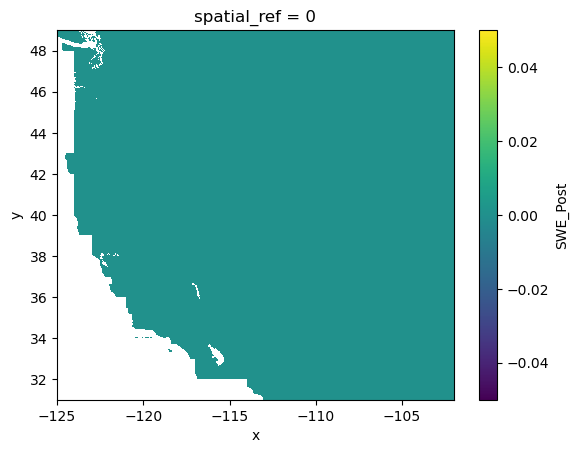

In [17]:
(ds.SWE_Post.mean(dim='Year') - ds1.SWE_Post.mean(dim='Year')).plot(robust=True)

In [5]:
ds_stdev = ds.SWE_Post.std(dim='Year', skipna=True, ddof=1)

In [6]:
ds_stdev.to_netcdf('../data/reanalysis/SWE_reanalysis_32years_stdev.nc')

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

In [27]:
xr.open_dataset('../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc')

<xarray.Dataset>
Dimensions:    (Latitude: 4050, Longitude: 5175)
Coordinates:
  * Latitude   (Latitude) float64 31.0 31.01 31.01 31.02 ... 48.99 48.99 49.0
  * Longitude  (Longitude) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
Data variables:
    SWE_Post   (Longitude, Latitude) float32 ...

In [35]:
ds.SWE_Post

<xarray.DataArray 'SWE_Post' (Year: 32, y: 4050, x: 5175)>
dask.array<concatenate, shape=(32, 4050, 5175), dtype=float32, chunksize=(1, 4050, 5175), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
  * Year         (Year) int64 1990 1991 1992 1993 1994 ... 2018 2019 2020 2021
Attributes:
    Units:    meters

### Calculate annual SWE anomolies from the 32-year mean:  
Exclude pixels with <0.1 mm SWE

In [5]:
anomalies = ds.SWE_Post - ds.SWE_Post.mean(dim='Year').where(ds.SWE_Post.mean(dim='Year')>0.1)

In [19]:
mean_swe = ds.SWE_Post.mean(dim='Year').where(ds.SWE_Post.mean(dim='Year')>0.1)

In [20]:
mean_swe.shape

(4050, 5175)

### Calculate standard deviation of the SWE data and mask 0 values:

In [7]:
ds_stdev = ds.SWE_Post.std(dim='Year')

### Standardized by dividing the anomolies by the standard deviation:

In [29]:
anomalies_sdev = anomalies / ds_stdev

### Coarsen the data to make functions run faster:  
Here I combine cells by a factor of 8 using the mean

In [353]:
anomalies_coarser = anomalies.coarsen(x=8, boundary='trim').mean().coarsen(y=8, boundary='trim').mean()

In [354]:
anomalies_sdev_coarser = anomalies_sdev.coarsen(x=8, boundary='trim').mean().coarsen(y=8, boundary='trim').mean()

<Axes: >

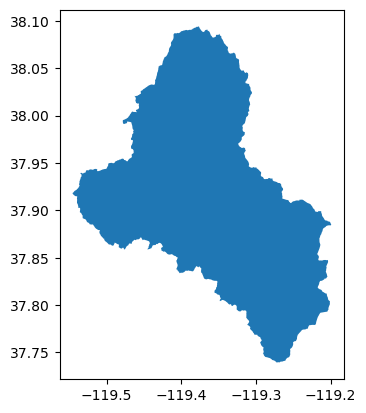

In [8]:
huc10_wus[huc10_wus['name']=='Headwaters Tuolumne River'].plot()

### Steps:  
* subset snotel sites within huc10 watershed
* Pull the swe reanalysis gridcell at each snotel site
* Find the ratio between snotel swe and swe reanalysis swe: snotel/gridcell = uswe
* Need to figure out whether we can just use april 1 swe, or need to use accumulated swe for both products and then run the regression (which includes number of snowfall events as a predictor variable) that Justin used.
* Calculate μSWEþ for the full watershed as the median (in time) μSWE calculated from each individual snow pillow ???

  I wouldn't expect the relationship at the gridcell to the snotel site to hold throughout the basin, so it doesn't make sense to just do a simple anomaly offset. However, I don't have pattern data like Justin did that would allow me to determine a relationship at all locations within the watershed.
    
  I also don't just expect that including snotel data offsetting will make the pre look more like the post, because the methods are different - post doesn't include snotel data. But, we do have metrics comparing snotel to swe reanalysis (at peak swe, not april 1) so we could do a similar comparison with our corrected data. But then it's not an independent comparison. Would it make sense to do a test case scenario where we do use ASO data to compare to?...although that won't work if we only want to compare April 1.
    
  What if we correct the anomalies, so that the ratio is the same everywhere? Is that different than using the multiplier at the location of snotel sites? there are different mechanisms at different locations in a watershed depending on the year, so does it make sense to do a blanket correction like that? - we are mainly focused on watershed totals, not individual distribution within the watershed. Does it all even out across the basin?
    
  How do we incorporate multiple snotel measurements? Do we use the average anomaly at all the sites, or can we use all the data without a summary statistic? Will it even change that much by averaging more than 1 or 2 snotel stations, if those stations are within what we've already determined to be areas of similar anomalies?
    
  Justin used the accumulation throughout a season, whereas we are only using April 1. 

* first steps: pull snotel site anomalies within tuolumne headwaters and compare them between years. They fall within the same cluster but how similar are they really? Then pull from wider and wider radius. this will show whether a composite metric will perform differently than just within-watershed snotel anomalies. ie does pulling from outside the watershed have the potential to improve bias-correction?
* then compare anomaly at snotel site to anomaly of swe reanalysis to see how different they are, within watershed.
* and look at the distribution of anomalies within the watershed, and also the cluster. how consistent is it actually?
* My idea for the bias-correction (without the use of patterns like Justin had) is to take the mean/median anomaly of relevant snotel sites and use it to make the basin total have that same anomaly - so each gridcell get's offset such that it's anomaly matches snotel?
* Then how do we define success/error metrics - offset Prior to try to match Post? also could compare to ASO totals but timing isn't exactly April 1 and we can't do this on a larger scale.

In [3]:
station_clusters.head()

,name,network,elevation_m,geometry,cluster_anom
code,,,,,
301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,POINT Z (-120.79192 41.23583 1886.71204),3
302_OR_SNTL,Aneroid Lake #2,SNOTEL,2255.520020,POINT Z (-117.19258 45.21328 2255.52002),0
303_CO_SNTL,Apishapa,SNOTEL,3048.000000,POINT Z (-105.06749 37.33062 3048.00000),2
304_OR_SNTL,Arbuckle Mtn,SNOTEL,1758.696045,POINT Z (-119.25392 45.19085 1758.69604),0
306_ID_SNTL,Atlanta Summit,SNOTEL,2310.384033,POINT Z (-115.23907 43.75690 2310.38403),3


In [8]:
station_clusters.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [78]:
tuol_huc10 = huc10_wus[huc10_wus['name']=='Headwaters Tuolumne River'].to_crs('epsg:4326')
eriv_huc10 = huc10_wus.loc[(huc10_wus['states']=='CO') & (huc10_wus['name'].str.contains('East River'))].to_crs('epsg:4326')

In [21]:
ds.rio.crs

CRS.from_epsg(4326)

In [22]:
tuol_huc10.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
tuol_reanalysis = ds.SWE_Post.rio.clip(tuol_huc10)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape huc2 at index 0 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape tnmid at index 1 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape metasource at index 2 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rasterio/features.py:328: S

type: No valid geometry objects found for rasterize

(37.5, 38.3)

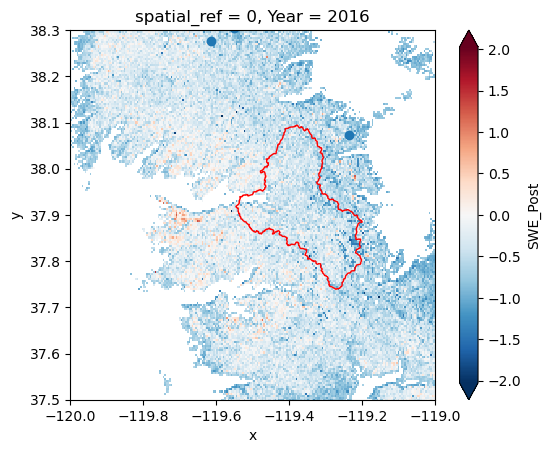

In [31]:
fig, ax = plt.subplots()
anomalies_sdev[26].plot(ax=ax, robust=True)
station_clusters.plot(ax=ax)
tuol_huc10.plot(ax=ax, facecolor='none', edgecolor='red')
ax.set_xlim(-120, -119)
ax.set_ylim(37.5,38.3)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(37.5, 38.3)

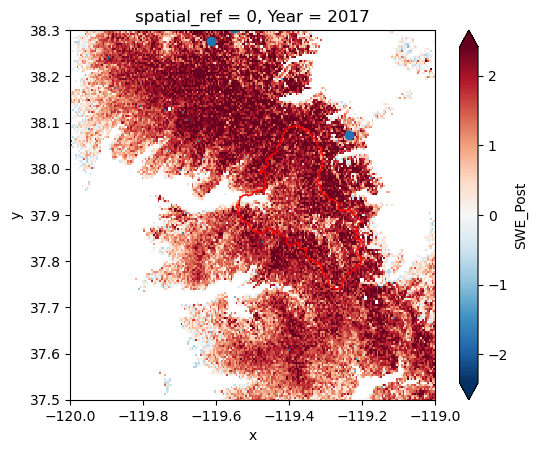

In [32]:
fig, ax = plt.subplots()
anomalies_sdev[27].plot(ax=ax, robust=True)
station_clusters.plot(ax=ax)
tuol_huc10.plot(ax=ax, facecolor='none', edgecolor='red')
ax.set_xlim(-120, -119)
ax.set_ylim(37.5,38.3)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


(37.5, 38.3)

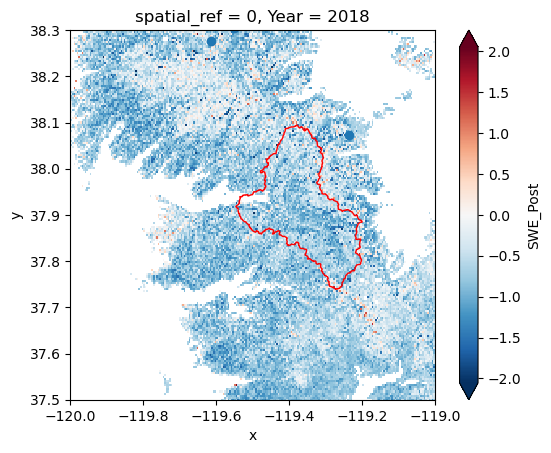

In [34]:
fig, ax = plt.subplots()
anomalies_sdev[28].plot(ax=ax, robust=True)
station_clusters.plot(ax=ax)
tuol_huc10.plot(ax=ax, facecolor='none', edgecolor='red')
ax.set_xlim(-120, -119)
ax.set_ylim(37.5,38.3)

In [33]:
station_anom[station_anom.index.year == 2017]

,301_CA_SNTL,302_OR_SNTL,303_CO_SNTL,304_OR_SNTL,306_ID_SNTL,308_AZ_SNTL,309_WY_SNTL,310_AZ_SNTL,311_MT_SNTL,312_ID_SNTL,...,874_CO_SNTL,875_WY_SNTL,877_AZ_SNTL,PLP,UBC,CRL,CSV,CAP,HHM,BLD
2017-04-01 00:00:00+00:00,1.299926,0.697283,0.447155,0.631711,2.292632,-0.438781,0.126182,-0.671011,-0.142021,2.025732,...,1.10114,-0.026607,-0.321617,1.657916,1.358616,-1.687056,1.668196,1.881864,2.624241,0.619445


In [36]:
import plotly.express as px

In [37]:
station_clusters.geometry

code
301_CA_SNTL     POINT Z (-120.79192 41.23583 1886.71204)
302_OR_SNTL     POINT Z (-117.19258 45.21328 2255.52002)
303_CO_SNTL     POINT Z (-105.06749 37.33062 3048.00000)
304_OR_SNTL     POINT Z (-119.25392 45.19085 1758.69604)
306_ID_SNTL     POINT Z (-115.23907 43.75690 2310.38403)
                                 ...                    
CRL            POINT Z (-118.42601 36.77752 10400.00000)
CSV             POINT Z (-118.26769 36.19810 8300.00000)
CAP             POINT Z (-120.04158 38.71079 8000.00000)
HHM             POINT Z (-119.80563 38.49066 8700.00000)
BLD             POINT Z (-120.03488 38.45126 7200.00000)
Name: geometry, Length: 511, dtype: geometry

In [41]:
station_anom[station_anom.index.year == 2017].T

,2017-04-01 00:00:00+00:00
301_CA_SNTL,1.299926
302_OR_SNTL,0.697283
303_CO_SNTL,0.447155
304_OR_SNTL,0.631711
306_ID_SNTL,2.292632
...,...
CRL,-1.687056
CSV,1.668196
CAP,1.881864
HHM,2.624241


In [51]:
station_clusters.geometry.x

code
301_CA_SNTL   -120.791924
302_OR_SNTL   -117.192581
303_CO_SNTL   -105.067490
304_OR_SNTL   -119.253922
306_ID_SNTL   -115.239067
                  ...    
CRL           -118.426010
CSV           -118.267685
CAP           -120.041580
HHM           -119.805626
BLD           -120.034882
Length: 511, dtype: float64

In [55]:
station_anom[station_anom.index.year == 2017].T.index

Index(['301_CA_SNTL', '302_OR_SNTL', '303_CO_SNTL', '304_OR_SNTL',
       '306_ID_SNTL', '308_AZ_SNTL', '309_WY_SNTL', '310_AZ_SNTL',
       '311_MT_SNTL', '312_ID_SNTL',
       ...
       '874_CO_SNTL', '875_WY_SNTL', '877_AZ_SNTL', 'PLP', 'UBC', 'CRL', 'CSV',
       'CAP', 'HHM', 'BLD'],
      dtype='object', length=511)

In [66]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergeo(
        lon = station_clusters.geometry.x,
        lat = station_clusters.geometry.y,
        text = station_anom[station_anom.index.year == 2017].T.index,
        mode = 'markers',
        marker_color = station_anom[station_anom.index.year == 2017].T['2017-04-01 00:00:00+00:00'], #2017-04-01 00:00:00+00:00
        ))

fig.update_layout(
        title = '2017 Snotel Anomalies',
        geo_scope='usa',
    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<Axes: >

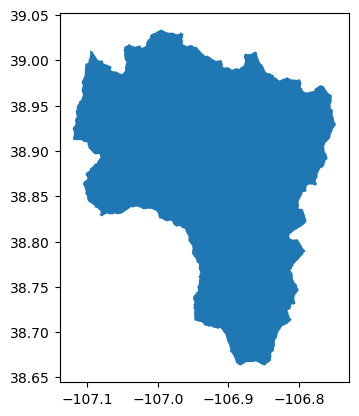

In [68]:
eriv_huc10.plot()

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning:

invalid value encountered in divide



(38.5, 39.1)

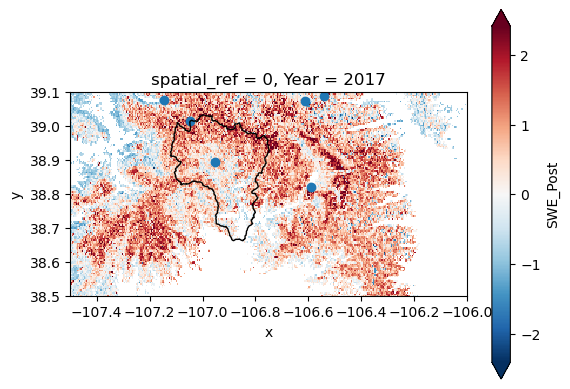

In [98]:
fig, ax = plt.subplots()
anomalies_sdev[27].plot(ax=ax, robust=True)
station_clusters.plot(ax=ax)
eriv_huc10.plot(ax=ax, facecolor='none', edgecolor='k')
ax.set_xlim(-107.5, -106)
ax.set_ylim(38.5,39.1)

In [149]:
anomalies_sdev.rio.crs

CRS.from_epsg(4326)

(38.5, 39.1)

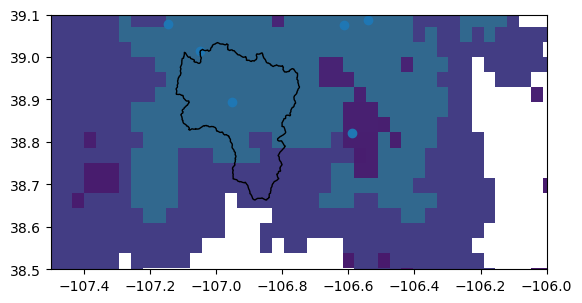

In [101]:
fig, ax = plt.subplots()
#anomalies_sdev[27].plot(ax=ax, robust=True)
cluster_polys.plot(ax=ax,cmap='viridis')
station_clusters.plot(ax=ax)
eriv_huc10.plot(ax=ax, facecolor='none', edgecolor='k')

ax.set_xlim(-107.5, -106)
ax.set_ylim(38.5,39.1)

In [71]:
import folium

In [73]:
station_clusters.head()

,name,network,elevation_m,geometry,cluster_anom
code,,,,,
301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,POINT Z (-120.79192 41.23583 1886.71204),3
302_OR_SNTL,Aneroid Lake #2,SNOTEL,2255.520020,POINT Z (-117.19258 45.21328 2255.52002),0
303_CO_SNTL,Apishapa,SNOTEL,3048.000000,POINT Z (-105.06749 37.33062 3048.00000),2
304_OR_SNTL,Arbuckle Mtn,SNOTEL,1758.696045,POINT Z (-119.25392 45.19085 1758.69604),0
306_ID_SNTL,Atlanta Summit,SNOTEL,2310.384033,POINT Z (-115.23907 43.75690 2310.38403),3


In [80]:
station_clusters.index[0]

'301_CA_SNTL'

In [79]:
import folium

m = folium.Map(location=[38.9,-107], tiles="OpenStreetMap", zoom_start=12)



#for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
sim_geo = gpd.GeoSeries(eriv_huc10["geometry"]).simplify(tolerance=0.001)
geo_j = sim_geo.to_json()
geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
#folium.Popup(r["BoroName"]).add_to(geo_j)
geo_j.add_to(m)

for i in range(0,len(station_clusters)):
    folium.Circle(
      location=[station_clusters.iloc[i].geometry.y, station_clusters.iloc[i].geometry.x],
      popup=station_clusters.index[i],
      #radius=float(df.iloc[i]['km'])*15,
      color='crimson',
      fill=True,
      fill_color='crimson'
    ).add_to(m)
# for j in range(0,len(df3)):
#     folium.CircleMarker(
#       location=[df3.iloc[j]['lat'], df3.iloc[j]['lon']],
#       popup=df3.iloc[j]['type'],
#       radius=5,
#       color="#3186cc",
#       fill=True,
#       fill_color="#3186cc",
#     ).add_to(m)

# Show the map again
m

In [108]:
station_anom['380_CO_SNTL']

1990-04-01 00:00:00+00:00   -1.503178
1991-04-01 00:00:00+00:00   -0.368494
1992-04-01 00:00:00+00:00   -0.524235
1993-04-01 00:00:00+00:00    2.212355
1994-04-01 00:00:00+00:00   -0.501986
1995-04-01 00:00:00+00:00    1.455899
1996-04-01 00:00:00+00:00    1.544894
1997-04-01 00:00:00+00:00    1.122169
1998-04-01 00:00:00+00:00   -0.412991
1999-04-01 00:00:00+00:00   -0.857965
2000-04-01 00:00:00+00:00   -0.235002
2001-04-01 00:00:00+00:00   -0.702224
2002-04-01 00:00:00+00:00   -0.946960
2003-04-01 00:00:00+00:00   -0.146007
2004-04-01 00:00:00+00:00   -0.635478
2005-04-01 00:00:00+00:00    0.855184
2006-04-01 00:00:00+00:00    0.254469
2007-04-01 00:00:00+00:00   -0.657727
2008-04-01 00:00:00+00:00    1.745132
2009-04-01 00:00:00+00:00    0.610449
2010-04-01 00:00:00+00:00   -0.457489
2011-04-01 00:00:00+00:00    0.654946
2012-04-01 00:00:00+00:00   -1.681167
2013-04-01 00:00:00+00:00   -1.169447
2014-04-01 00:00:00+00:00    0.476956
2015-04-01 00:00:00+00:00   -0.657727
2016-04-01 0

In [88]:
station_clusters.loc['380_CO_SNTL']

name                                                        Butte
network                                                    SNOTEL
elevation_m                                           3096.768066
geometry        POINT Z (-106.9530029296875 38.89432907104492 ...
cluster_anom                                                    3
Name: 380_CO_SNTL, dtype: object

In [115]:
station_swe.columns

Index(['301_CA_SNTL', '302_OR_SNTL', '303_CO_SNTL', '304_OR_SNTL',
       '306_ID_SNTL', '308_AZ_SNTL', '309_WY_SNTL', '310_AZ_SNTL',
       '311_MT_SNTL', '312_ID_SNTL',
       ...
       '874_CO_SNTL', '875_WY_SNTL', '877_AZ_SNTL', 'PLP', 'UBC', 'CRL', 'CSV',
       'CAP', 'HHM', 'BLD'],
      dtype='object', length=511)

In [133]:
station_mean_sdev

,mean_swe,stdev
301_CA_SNTL,0.272574,0.161568
302_OR_SNTL,0.577612,0.158799
303_CO_SNTL,0.124381,0.113785
304_OR_SNTL,0.409972,0.151158
306_ID_SNTL,0.725249,0.204372
...,...,...
CRL,0.573413,0.339890
CSV,0.413536,0.251063
CAP,0.684847,0.369791
HHM,0.982623,0.494732


In [136]:
station_N = (station_swe['380_CO_SNTL']['2017-04-01 00:00:00+00:00'] - station_mean_sdev['mean_swe']['380_CO_SNTL']) / station_mean_sdev['stdev']['380_CO_SNTL']

In [244]:
station_N

1.5448938929201965

In [123]:
station_swe.columns = station_swe.columns.astype('str')

In [127]:
station_swe.columns.dtype

dtype('O')

In [137]:
ds.SWE_Post[27]

<xarray.DataArray 'SWE_Post' (y: 4050, x: 5175)>
dask.array<getitem, shape=(4050, 5175), dtype=float32, chunksize=(4050, 5175), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
    Year         int64 2017
Attributes:
    Units:    meters

In [ ]:
mean_swe

In [ ]:
ds_stdev

### Interpolate Reanalysis Product at Snotel Location

To interpolate at each snotel location:  
* SWE
* Mean SWE
* SWE standard deviation
  

Can I rewrite the function to work on files that have been preloaded, either data array or tifs?

In [28]:
coord = [station_clusters.loc['380_CO_SNTL'].geometry.x, station_clusters.loc['380_CO_SNTL'].geometry.y]

In [9]:
coord

[-106.9530029296875, 38.89432907104492]

In [ ]:
value=[]

for xx,yy in enumerate([polyRast_cent.geometry.x.values,polyRast_cent.geometry.y.values]):`

value.append(a.sel(x=xx,y=yy,method='nearest').values)

In [6]:
# Using the method from https://www.reddit.com/r/gis/comments/127wvn5/sample_raster_values_in_rioxarray_stack_by_points/

ds.SWE_Post[27].sel(x=coord[0],y=coord[1], method='nearest').values

array(0.5952, dtype=float32)

In [35]:
station_swe['380_CO_SNTL']['2017-04-01 00:00:00+00:00']

0.5334

In [21]:
station_clusters.loc['380_CO_SNTL']

name                                                        Butte
network                                                    SNOTEL
elevation_m                                           3096.768066
geometry        POINT Z (-106.9530029296875 38.89432907104492 ...
cluster_anom                                                    3
Name: 380_CO_SNTL, dtype: object

In [27]:
station_clusters

,name,network,elevation_m,geometry,cluster_anom
code,,,,,
301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,POINT Z (-120.79192 41.23583 1886.71204),3
302_OR_SNTL,Aneroid Lake #2,SNOTEL,2255.520020,POINT Z (-117.19258 45.21328 2255.52002),0
303_CO_SNTL,Apishapa,SNOTEL,3048.000000,POINT Z (-105.06749 37.33062 3048.00000),2
304_OR_SNTL,Arbuckle Mtn,SNOTEL,1758.696045,POINT Z (-119.25392 45.19085 1758.69604),0
306_ID_SNTL,Atlanta Summit,SNOTEL,2310.384033,POINT Z (-115.23907 43.75690 2310.38403),3
...,...,...,...,...,...
CRL,CHARLOTTE LAKE,CDEC,3169.920000,POINT Z (-118.42601 36.77752 10400.00000),2
CSV,CASA VIEJA MEADOWS,CDEC,2529.840000,POINT Z (-118.26769 36.19810 8300.00000),3
CAP,CAPLES LAKE,CDEC,2438.400000,POINT Z (-120.04158 38.71079 8000.00000),3


In [34]:
ds.SWE_Post[27].sel(x=coord[0],y=coord[1], method='nearest')

<xarray.DataArray 'SWE_Post' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    y            float64 38.9
    x            float64 -107.0
    spatial_ref  int64 0
    Year         int64 2017
Attributes:
    Units:    meters

In [38]:
coord

[-106.9530029296875, 38.89432907104492]

(38.87, 38.91)

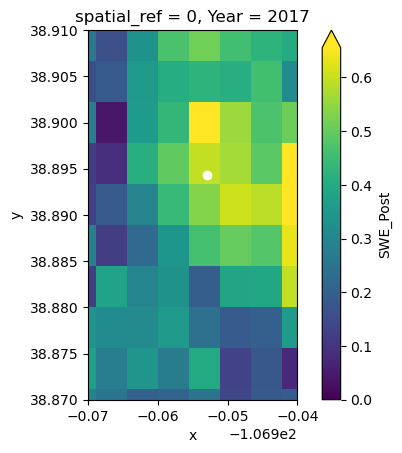

In [40]:
fig, ax = plt.subplots()

ax.set_xlim(-106.97, -106.94)
ax.set_ylim(38.87, 38.91)

ds.SWE_Post[27].plot(ax=ax, robust=True)
station_clusters.plot(ax=ax, legend=True, color='white')

ax.set_xlim(-106.97, -106.94)
ax.set_ylim(38.87, 38.91)

In [ ]:
fig, ax = plt.subplots()

ax.set_xlim(-106.97, -106.94)
ax.set_ylim(38.87, 38.91)

ds_std.plot(ax=ax, robust=True)
station_clusters.plot(ax=ax, legend=True, color='white')

ax.set_xlim(-106.97, -106.94)
ax.set_ylim(38.87, 38.91)

In [6]:
ds_std = ds.SWE_Post.std(dim='Year', skipna=True).where(ds.SWE_Post.mean(dim='Year')>0.1)

In [8]:
ds_std = ds_std.rio.write_nodata(np.nan, inplace=True)

In [9]:
ds_std.rio.nodata

nan

In [ ]:
# Colorado, 2011 was a big snow year (particularly later in the winter)- 09/10

In [ ]:
# Conceptual description of the steps to take:

# Calculate snotel N
snotel_swe = index(snotel_swe['location']['year'])
snotel_swe_mean = index(snotel_mean['location'])
snotel_swe_sdev = index(snotel_sdev['location'])
snotel_n = (snotel_swe - snotel_swe_mean)/snotel_sdev

# Calculate reanalysis N
reanalysis_swe = sample(ds.SWE_Post['year']['location'])
reanalysis_mean = sample(ds.SWE_Post.mean()['location'])
reanalysis_stdev = sample(ds.SWE_Post.stdev()['location'])
reanalysis_n = (reanalysis_swe - reanalysis_mean)/reanalysis_stdev

In [19]:
mean_swe = ds1.SWE_Post.mean(dim='Year').where(ds1.SWE_Post.mean(dim='Year')>0.1)

In [20]:
# Need to double check this - do I need to transpose this somehow?

std_swe = ds1.SWE_Post.std(dim='Year', skipna=True).where(ds1.SWE_Post.mean(dim='Year')>0.1)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [72]:
alt_std = ds1.SWE_Post.std(dim='Year', skipna=True, ddof=1)

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [36]:
# Calculate snotel N
station_n = (station_swe['380_CO_SNTL']['2017-04-01 00:00:00+00:00'] - station_mean_sdev['mean_swe']['380_CO_SNTL']) / station_mean_sdev['stdev']['380_CO_SNTL']

# Calculate reanalysis N
reanalysis_swe = ds1.SWE_Post[27].sel(x=coord[0],y=coord[1], method='nearest').values
reanalysis_mean = mean_swe.sel(x=coord[0],y=coord[1], method='nearest').values
reanalysis_stdev = std_swe.sel(x=coord[0],y=coord[1], method='nearest').values
reanalysis_n = (reanalysis_swe - reanalysis_mean)/reanalysis_stdev

print(station_n)
print(reanalysis_n)

1.5448938929201965
1.236881


In [42]:
# Calculate snotel N
station_n = (station_swe['380_CO_SNTL']['2010-04-01 00:00:00+00:00'] - station_mean_sdev['mean_swe']['380_CO_SNTL']) / station_mean_sdev['stdev']['380_CO_SNTL']

# Calculate reanalysis N
reanalysis_swe = ds1.SWE_Post[20].sel(x=coord[0],y=coord[1], method='nearest').values
reanalysis_mean = mean_swe.sel(x=coord[0],y=coord[1], method='nearest').values
reanalysis_stdev = std_swe.sel(x=coord[0],y=coord[1], method='nearest').values
reanalysis_n = (reanalysis_swe - reanalysis_mean)/reanalysis_stdev

print('station N: ', station_n)
print('reanalysis N: ', reanalysis_n)
print('station swe: ', station_swe['380_CO_SNTL']['2010-04-01 00:00:00+00:00'])
print('reanalysis swe: ', reanalysis_swe)
print('station mean: ', station_mean_sdev['mean_swe']['380_CO_SNTL'])
print('reanalysis mean: ', reanalysis_mean)

station N:  -0.45748883057672834
reanalysis N:  0.23884968
station swe:  0.30479999999999996
reanalysis swe:  0.46
station mean:  0.35702875
reanalysis mean:  0.42764384


In [52]:
station_ns = []
reanalysis_ns = []

for year in range(1990, 2022):
    station_ns.append((station_swe['380_CO_SNTL'][f'{year}-04-01 00:00:00+00:00'] - station_mean_sdev['mean_swe']['380_CO_SNTL']) / station_mean_sdev['stdev']['380_CO_SNTL'])

    reanalysis_swe = ds1.SWE_Post[year-1990].sel(x=coord[0],y=coord[1], method='nearest').values
    reanalysis_mean = mean_swe.sel(x=coord[0],y=coord[1], method='nearest').values
    reanalysis_stdev = std_swe.sel(x=coord[0],y=coord[1], method='nearest').values
    reanalysis_ns.append((reanalysis_swe - reanalysis_mean)/reanalysis_stdev)

In [73]:
df_ns = pd.DataFrame({'station_ns':station_ns, 'reanalysis_ns':reanalysis_ns}, index=list(range(1990, 2022)))
df_ns.head()

,station_ns,reanalysis_ns
1990,-1.503178,-0.644024
1991,-0.368494,-0.834477
1992,-0.524235,0.250661
1993,2.212355,-0.168631
1994,-0.501986,-0.793139


In [85]:
temps  = pd.read_csv('../data/max_temp_mean_butte.csv')

In [89]:
temps.index = temps['Year']

In [93]:
temps = temps.drop(columns='Year')

In [95]:
temps.head()

,max_temp_mean
Year,
1990,-1.9225
1991,-2.6120
1992,-1.4500
1993,-2.7850
1994,-1.7050


In [96]:
df_ns['temps'] = temps['max_temp_mean']

In [106]:
r2 = np.corrcoef(df_ns['station_ns'], df_ns['reanalysis_ns'])
r2[0,1]

0.6985623361305153

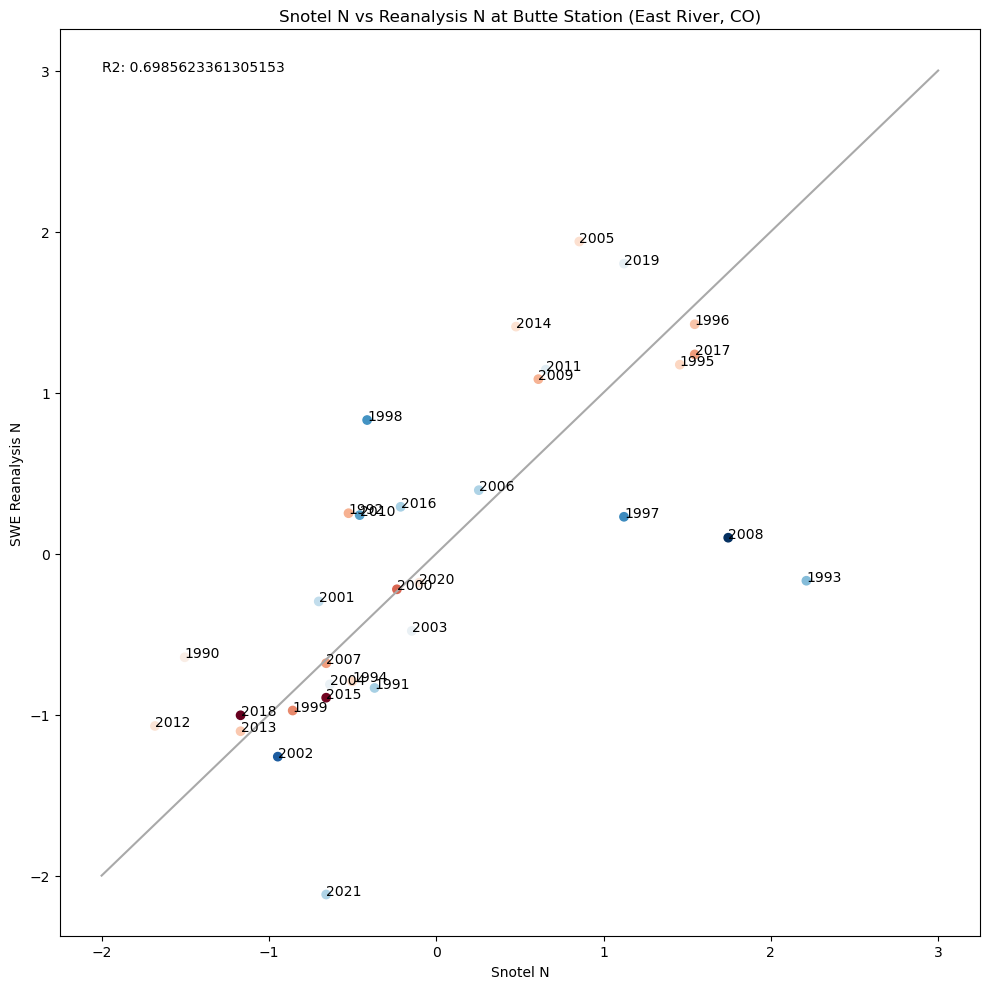

In [114]:
x = np.linspace(-2,3,100)
y = x

fig, ax = plt.subplots(figsize=(10,10)) #

plt.scatter(df_ns['station_ns'],df_ns['reanalysis_ns'], c=df_ns['temps'], cmap='RdBu_r')

for i in df_ns.index:
    ax.annotate(i, (df_ns['station_ns'][i], df_ns['reanalysis_ns'][i]))

ax.plot(x, y, 'darkgrey', label='1:1 line')
ax.set_title('Snotel N vs Reanalysis N at Butte Station (East River, CO)')
ax.annotate(f"R2: {r2[0,1]}", xy=(-2,3))
ax.set_xlabel('Snotel N')
ax.set_ylabel('SWE Reanalysis N')

plt.tight_layout()
plt.savefig('../figures/n_comparison.jpeg')

In [ ]:
station_ns = []
reanalysis_ns = []

for year in range(1990, 2022):
    station_ns.append((station_swe['380_CO_SNTL'][f'{year}-04-01 00:00:00+00:00'] - station_mean_sdev['mean_swe']['380_CO_SNTL']) / station_mean_sdev['stdev']['380_CO_SNTL'])

    reanalysis_swe = ds1.SWE_Post[year-1990].sel(x=coord[0],y=coord[1], method='nearest').values
    reanalysis_mean = mean_swe.sel(x=coord[0],y=coord[1], method='nearest').values
    reanalysis_stdev = std_swe.sel(x=coord[0],y=coord[1], method='nearest').values
    reanalysis_ns.append((reanalysis_swe - reanalysis_mean)/reanalysis_stdev)

## Mess with Friedrich's Core Interpolate function to use not just nearest neighbor

In [39]:
# This function was written by Friedrich Knuth, UW and is contained in core.py
# The sampling technique can be specified, here we use bicubic

# cluster_sample = core.interpolate('../../data/swe_reanalysis_5clusters.tif', coord, offset=3, kind='NN')

In [10]:
import core
Polygon = core.Polygon
replace_and_fill_nodata_value = core.replace_and_fill_nodata_value

In [11]:
# Edited by Friedrich to help me use this interpolate function on netcdf files
# He recommended testing it against the result of the original function after converting my netcdf to tif. 
# As shown below, they result in different numbers. So this function needs some tweaking.

def interpolate(raster_file_name, 
                positions, 
                offset=3, 
                kind="IDW", 
                netcdf_file_name = None, 
                variable_name = 'SWE_Post'):

    # source = rasterio.open(raster_file_name)
    source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)
    source = source.rename({'Longitude': 'x',
                            'Latitude': 'y',})
    source = source.rio.write_crs('EPSG:4326')
    # spacing = source.res[0]
    spacing = source.rio.resolution()[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
        # window, transform = rasterio.mask.mask(
        #     source, [window_polygon], crop=True, all_touched=True
        # 
        window_ds = source.rio.clip(window_polygon_geoseries, 
                                    crs=source.rio.crs)
        window = window_ds[variable_name].data
        transform = window_ds.rio.transform() # check
        
        window = window.squeeze()
        if source[variable_name].rio.nodata != None:
            window = replace_and_fill_nodata_value(window, source[variable_name].rio.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return np.array(results)


In [12]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="mean", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

array([0.39411667], dtype=float32)

In [35]:
netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc'
offset = 3
positions = [coord,]
variable_name = 'SWE_Post'
source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)

In [36]:
source = source.rio.write_crs('EPSG:4326')

In [37]:
source = source.rename({'Longitude': 'x',
               'Latitude': 'y',})

In [52]:
source = source.rio.to_crs('epsg:32612')

type: 'RasterDataset' object has no attribute 'to_crs'

In [45]:
spacing = source.rio.resolution()[0]
dx = offset * spacing
dy = offset * spacing

In [50]:
spacing

0.0044445956495216465

In [51]:
source.rio.resolution()

(0.0044445956495216465, 0.004444426152405252)

In [41]:
source

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
Data variables:
    SWE_Post     (x, y) float32 ...

In [43]:
coord

[-106.9530029296875, 38.89432907104492]

In [48]:
coord[1] + dy

38.907662857993486

In [49]:
coord[1] - dy

38.88099528409636

In [47]:
source.sel(x=slice(coord[0] - dx, coord[0] + dx), y=slice(coord[1] + dy, coord[1] - dy))

<xarray.Dataset>
Dimensions:      (y: 0, x: 6)
Coordinates:
  * y            (y) float64 
  * x            (x) float64 -107.0 -107.0 -107.0 -106.9 -106.9 -106.9
    spatial_ref  int64 0
Data variables:
    SWE_Post     (x, y) float32 ...

In [231]:
# spacing = source.rio.resolution()[0]
# dx = offset * spacing
# dy = offset * spacing

# results = []

In [232]:
# for p in positions:
#     UL = (p[0] - dx, p[1] + dy)
#     UR = (p[0] + dx, p[1] + dy)
#     LR = (p[0] + dx, p[1] - dy)
#     LL = (p[0] - dx, p[1] - dy)

# window_polygon = Polygon([UL, UR, LR, LL, UL])

In [233]:
# window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
# # window, transform = rasterio.mask.mask(
# #     source, [window_polygon], crop=True, all_touched=True
# # 
# window_ds = source.rio.clip(window_polygon_geoseries, 
#                             crs=source.rio.crs)
# window = window_ds[variable_name].data
# transform = window_ds.rio.transform

In [235]:
# transform()

Affine(0.00444793701171875, 0.0, -106.96886825561523,
       0.0, 0.004444122314453125, 38.88000679016113)

### Convert to tif:

In [140]:
base_dir = '../data/reanalysis/swe/'
year = 2017
yr_dir = f'{base_dir}{year}/SWE_Post/'
fname = f'{base_dir}{year}/SWE_Post/{os.listdir(yr_dir)[0]}'
#fname_lst.append(f'{base_dir}{year}/SWE_Post/{fname}')
## load netcdf ##
def preprocess(ds):
    ds['SWE_Post'] = ds['SWE_Post'].T
    ## set spatial reference ##
    ds.rio.write_crs('EPSG:4326',inplace = True)
    ds = ds.rename({'Latitude':'y','Longitude':'x'})
    ds = ds.rio.set_spatial_dims('y','x',inplace=True)
    return ds
    # ds.expand_dims(dim = 'Year')
    
## load files and concatenate by Year ##
ds = xr.open_mfdataset(fname, concat_dim = 'Year',combine = 'nested', preprocess = preprocess)
## rename years ##
#ds['Year'] = 2017
ds.rio.write_crs('epsg:4326')
ds

<xarray.Dataset>
Dimensions:      (y: 4050, x: 5175, Year: 1)
Coordinates:
  * y            (y) float64 31.0 31.01 31.01 31.02 ... 48.98 48.99 48.99 49.0
  * x            (x) float64 -125.0 -125.0 -125.0 ... -102.0 -102.0 -102.0
    spatial_ref  int64 0
Dimensions without coordinates: Year
Data variables:
    SWE_Post     (Year, y, x) float32 dask.array<chunksize=(1, 4050, 5175), meta=np.ndarray>

In [239]:
ds.SWE_Post.rio.to_raster('../data/reanalysis_2017_swe.tif')

In [243]:
ds.rio.crs

CRS.from_epsg(4326)

In [14]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="mean", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

array([0.39411667], dtype=float32)

In [17]:
def interpolate(raster_file_name, 
                positions, 
                offset=3, 
                kind="IDW", 
                netcdf_file_name = None, 
                variable_name = 'SWE_Post'):

    # source = rasterio.open(raster_file_name)
    source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)
    source = source.rename({'Longitude': 'x',
                            'Latitude': 'y',})
    source = source.rio.write_crs('EPSG:4326')
    # spacing = source.res[0]
    spacing = source.rio.resolution()[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
        # window, transform = rasterio.mask.mask(
        #     source, [window_polygon], crop=True, all_touched=True
        # 
        window_ds = source.rio.clip_box(minx=p[0] - dx, miny=p[1] - dy, maxx=p[0] + dx, maxy=p[1] + dy)
        window = window_ds[variable_name].data
        transform = window_ds.rio.transform() # check
        
        window = window.squeeze()
        if source[variable_name].rio.nodata != None:
            window = replace_and_fill_nodata_value(window, source[variable_name].rio.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return np.array(results)

In [21]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="mean", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

array([0.4224449], dtype=float32)

In [13]:
core.interpolate('../data/reanalysis_2017_swe.tif', [coord,], offset=3, kind='mean')

array([0.4224449], dtype=float32)

In [24]:
from scipy.interpolate import interp2d
def scipy_methods(window, coords_x, coords_y, center, kind="linear"):

    if window.shape[0] != window.shape[1]:
        return np.nan
    else:
        fun = interp2d(
            x=pd.unique(coords_x), y=pd.unique(coords_y), z=window, kind=kind
        )
        return fun(center[0], center[1])[0]

In [25]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="cubic", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:7: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  fun = interp2d(
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:10: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        

array([0.59223196])

In [26]:
core.interpolate('../data/reanalysis_2017_swe.tif', [coord,], offset=3, kind='cubic')

array([0.7012757])

In [33]:
def interpolate(raster_file_name, 
                positions, 
                offset=3, 
                kind="IDW", 
                netcdf_file_name = None, 
                variable_name = 'SWE_Post'):

    # source = rasterio.open(raster_file_name)
    source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)
    source = source.rename({'Longitude': 'x',
                            'Latitude': 'y',})
    source = source.rio.write_crs('EPSG:4326')
    # spacing = source.res[0]
    spacing = source.rio.resolution()[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
        # window, transform = rasterio.mask.mask(
        #     source, [window_polygon], crop=True, all_touched=True
        # 
        #window_ds = source.rio.clip_box(minx=p[0] - dx, miny=p[1] - dy, maxx=p[0] + dx, maxy=p[1] + dy)
        window = source.sel({x:slice(p[0] - dx, p[0] + dx), y:slice(p[1] + dy, p[1] - dy)})
        window = window_ds[variable_name].data
        transform = window_ds.rio.transform() # check
        
        window = window.squeeze()
        if source[variable_name].rio.nodata != None:
            window = replace_and_fill_nodata_value(window, source[variable_name].rio.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return np.array(results)

In [34]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="cubic", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

type: local variable 'x' referenced before assignment

In [137]:
def interpolate(raster_file_name, 
                positions, 
                offset=3, 
                kind="IDW", 
                netcdf_file_name = None, 
                variable_name = 'SWE_Post'):

    # source = rasterio.open(raster_file_name)
    source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)
    source = source.rename({'Longitude': 'x',
                            'Latitude': 'y',})
    source = source.rio.write_crs('EPSG:4326')
    # spacing = source.res[0]
    spacing = source.rio.resolution()[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
        # window, transform = rasterio.mask.mask(
        #     source, [window_polygon], crop=True, all_touched=True
        # 
        window_ds = source.rio.clip_box(minx=p[0] - dx, miny=p[1] - dy, maxx=p[0] + dx, maxy=p[1] + dy)
        window = window_ds[variable_name].data.T
        transform = window_ds.rio.transform() # check
        
        window = window.squeeze()
        if source[variable_name].rio.nodata != None:
            window = replace_and_fill_nodata_value(window, source[variable_name].rio.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return transform

In [138]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="cubic", 
            netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', 
            variable_name='SWE_Post')

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:7: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  fun = interp2d(
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:10: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        

Affine(0.00444793701171875, 0.0, -106.96886825561523,
       0.0, 0.004444122314453125, 38.88000679016113)

In [142]:
ds.rio.transform()

Affine(0.0044445956495216465, 0.0, -125.00000214401616,
       0.0, 0.004444426152405252, 31.00007232732907)

In [106]:
window_geoseries

array([[0.379 , 0.2962, 0.332 , 0.1928, 0.3858, 0.39  , 0.5964],
       [0.1164, 0.2246, 0.3442, 0.4584, 0.4996, 0.4812, 0.6312],
       [0.182 , 0.296 , 0.4406, 0.5326, 0.6046, 0.588 , 1.0238],
       [0.089 , 0.4138, 0.4944, 0.5952, 0.5676, 0.4888, 0.6878],
       [0.0396, 0.3562, 0.4336, 0.708 , 0.556 , 0.4696, 0.5078],
       [0.1832, 0.3542, 0.4054, 0.4234, 0.41  , 0.4562, 0.3124],
       [0.1572, 0.3318, 0.4668, 0.514 , 0.4582, 0.4234, 0.4008]],
      dtype=float32)

In [113]:
core.interpolate('../data/reanalysis_2017_swe.tif', [coord,], offset=3, kind='cubic')

array([0.7012757])

In [109]:
def interpolate(raster_file_name, positions, offset=3, kind="IDW"):

    source = rasterio.open(raster_file_name)
    spacing = source.res[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window, transform = rasterio.mask.mask(
            source, [window_polygon], crop=True, all_touched=True
        )
        window = window.squeeze()
        if source.nodata != None:
            window = replace_and_fill_nodata_value(window, source.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return results


In [110]:
import rasterio
interpolate('../data/reanalysis_2017_swe.tif', [coord,], offset=3, kind='cubic')

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:7: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  fun = interp2d(
/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_681/3878785937.py:10: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        

[0.7012757039688299]

In [ ]:
array([0.7012757])

In [97]:
window_geoseries

array([0.71259841])

In [86]:
window

array([[0.379 , 0.2962, 0.332 , 0.1928, 0.3858, 0.39  , 0.5964],
       [0.1164, 0.2246, 0.3442, 0.4584, 0.4996, 0.4812, 0.6312],
       [0.182 , 0.296 , 0.4406, 0.5326, 0.6046, 0.588 , 1.0238],
       [0.089 , 0.4138, 0.4944, 0.5952, 0.5676, 0.4888, 0.6878],
       [0.0396, 0.3562, 0.4336, 0.708 , 0.556 , 0.4696, 0.5078],
       [0.1832, 0.3542, 0.4054, 0.4234, 0.41  , 0.4562, 0.3124],
       [0.1572, 0.3318, 0.4668, 0.514 , 0.4582, 0.4234, 0.4008]],
      dtype=float32)

In [107]:
diff = window - window_geoseries

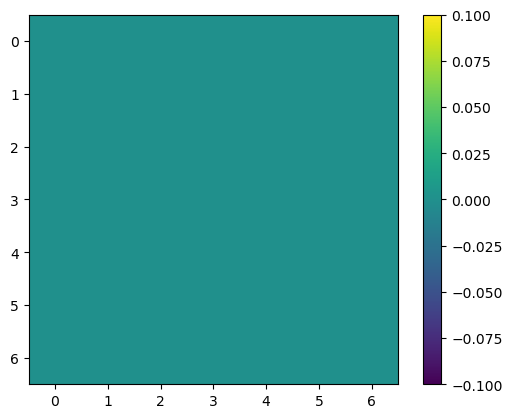

In [108]:
plt.imshow(diff)
plt.colorbar(plt.imshow(diff))

In [116]:
set(diff.flatten())

{0.0}

In [129]:
netcdf_file_name='../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc'
offset = 3
positions = [coord,]
variable_name = 'SWE_Post'
source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)

In [130]:
source = source.rio.write_crs('EPSG:4326')

In [131]:
source = source.rename({'Longitude': 'x',
               'Latitude': 'y',})

In [132]:
source = source.rio.to_crs('epsg:32612')

type: 'RasterDataset' object has no attribute 'to_crs'

In [133]:
spacing = source.rio.resolution()[0]
dx = offset * spacing
dy = offset * spacing

In [134]:

window_ds = source.rio.clip_box(minx=coord[0] - dx, miny=coord[1] - dy, maxx=coord[0] + dx, maxy=coord[1] + dy)
window = window_ds[variable_name].data
transform = window_ds[variable_name].rio.transform()

In [125]:
source = rasterio.open('../data/reanalysis_2017_swe.tif')
spacing = source.res[0]
dx = offset * spacing
dy = offset * spacing

UL = (coord[0] - dx, coord[1] + dy)
UR = (coord[0] + dx, coord[1] + dy)
LR = (coord[0] + dx, coord[1] - dy)
LL = (coord[0] - dx, coord[1] - dy)

window_polygon = Polygon([UL, UR, LR, LL, UL])
window, transform = rasterio.mask.mask(
    source, [window_polygon], crop=True, all_touched=True
)

In [135]:
transform

Affine(0.00444793701171875, 0.0, -106.96886825561523,
       0.0, 0.004444122314453125, 38.88000679016113)

In [126]:
transform

Affine(0.0044445956495216465, 0.0, -106.96827759390685,
       0.0, 0.004444426152405252, 38.88003989554358)

In [ ]:
Affine(0.00444793701171875, 0.0, -106.96886825561523,
       0.0, 0.004444122314453125, 38.88000679016113)

### Try again, with reprojected data:

In [152]:
ds_r = rxr.open_rasterio('../data/reanalysis/swe/2017/SWE_Post/swe_reanalysis_SWE_Post_2017_04_01.nc', crs='epsg:4326')

/Users/Hannah/micromamba/envs/analysis_2023/lib/python3.9/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


In [153]:
ds_r = ds_r.rio.set_crs('epsg:4326')

In [154]:
ds_r.rio.crs

CRS.from_epsg(4326)

In [156]:
ds_r_trans = ds_r.rio.reproject('epsg:32613')

In [157]:
ds_r_trans.to_netcdf("../data/swe_reanalysis_SWE_Post_2017_04_01_32613.nc")

In [170]:
ds = xr.open_dataset("../data/swe_reanalysis_SWE_Post_2017_04_01_32613.nc")

In [172]:
ds.SWE_Post.rio.nodata

nan

In [173]:
ds.rio.crs

In [159]:
ds_r_trans.rio.to_raster("../data/swe_reanalysis_SWE_Post_2017_04_01_32613.tif")

In [175]:

def interpolate(raster_file_name, 
                positions, 
                offset=3, 
                kind="IDW", 
                netcdf_file_name = None, 
                variable_name = 'SWE_Post'):

    # source = rasterio.open(raster_file_name)
    source = xr.open_dataset(netcdf_file_name, mask_and_scale = True)
    # source = source.rename({'Longitude': 'x',
    #                         'Latitude': 'y',})
    source = source.rio.write_crs('EPSG:32613')
    # spacing = source.res[0]
    spacing = source.rio.resolution()[0]
    dx = offset * spacing
    dy = offset * spacing

    results = []

    if kind == "IDW":
        IDW_power = find_optimal_georaster_IDW_power(
            raster_file_name, positions, offset=offset, powers=np.arange(0, 20, 0.1)
        )
    for p in positions:
        UL = (p[0] - dx, p[1] + dy)
        UR = (p[0] + dx, p[1] + dy)
        LR = (p[0] + dx, p[1] - dy)
        LL = (p[0] - dx, p[1] - dy)

        window_polygon = Polygon([UL, UR, LR, LL, UL])
        window_polygon_geoseries = gpd.GeoSeries({'geometry': window_polygon})
        # window, transform = rasterio.mask.mask(
        #     source, [window_polygon], crop=True, all_touched=True
        # 
        window_ds = source.rio.clip_box(minx=p[0] - dx, miny=p[1] - dy, maxx=p[0] + dx, maxy=p[1] + dy)
        window = window_ds[variable_name].data.T
        transform = window_ds.rio.transform() # check
        
        window = window.squeeze()
        if source[variable_name].rio.nodata != None:
            window = replace_and_fill_nodata_value(window, source[variable_name].rio.nodata, np.nan)
        if np.isnan(window).all():
            results.append(np.nan)

        else:
            coords = []
            for x in np.arange(0, window.shape[0], 1):
                for y in np.arange(0, window.shape[1], 1):
                    coords.append(transform * (x, y))
            coords = np.array(coords)
            coords_x = pd.unique(coords[:, 0]) + spacing / 2
            coords_y = pd.unique(coords[:, 1]) - spacing / 2

            if kind == "IDW":
                results.append(IDW(window, coords_x, coords_y, p, power=IDW_power))
            elif kind == "mean":
                results.append(np.nanmean(window))
            elif kind == "rio_NN":
                results.append(
                    list(source.sample([p,]))[
                        0
                    ][0]
                )
            elif kind == "NN":
                results.append(nearest_neighbor(window, coords_x, coords_y, p))
            elif kind == "linear":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="linear")
                )
            elif kind == "cubic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="cubic")
                )
            elif kind == "quintic":
                results.append(
                    scipy_methods(window, coords_x, coords_y, p, kind="quintic")
                )

    if kind == "rio_NN":
        results = replace_and_fill_nodata_value(
            np.array(results), source.nodata, np.nan
        )

    return window

In [176]:
interpolate(None, 
            [coord,], 
            offset=3, 
            kind="mean", 
            netcdf_file_name="../data/swe_reanalysis_SWE_Post_2017_04_01_32613.nc", 
            variable_name='SWE_Post')

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]], dtype=float32)

In [177]:
# To use Dask operators, load data using dask, ie: open_dataset(chunks='auto')
# ds['variable_name'].data

type: 'variable_name'